In [1]:
'''2nd attempt at testing a Vit-MAE linear probing model.
Follows on from code in vit_mae_standalone6.ipynb.'''

'2nd attempt at testing a Vit-MAE linear probing model.\nFollows on from code in vit_mae_standalone6.ipynb.'

In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from functools import partial

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data


from timm.models.vision_transformer import PatchEmbed, Block

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms


## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()



/tmp/ipykernel_31615/2819416866.py:32: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [3]:
# Configurations as dictionary
args = {
    'batch_size': 64, #8,#64, #8, #16, #32, #64,
    #'epochs': 100,#400,
    'accum_iter': 1,
    'model': 'mae_vit_base_patch16', #'mae_vit_large_patch16',
    'input_size': 224,
    'mask_ratio': 0.0, #0.75, # No masking because we are doing linear probing in this configuration
    'norm_pix_loss': False,
    #'weight_decay': 0.05,
    #'lr': None,
    #'blr': 1e-3,
    #'min_lr': 0.0,
    #'warmup_epochs': 5, # 40
    'data_path': 'data',
    #'output_dir': 'models/vitmae_linprobe_cifar10',
    #'log_dir': 'models/vitmae_linprobe_cifar10',
    'device': 'cuda:0',
    'seed': 42,
    #'resume': 'models/vitmae_cifar10/checkpoint-80.pth',
    #'start_epoch': 0,
    'num_workers': 10,
    'pin_mem': True,
    'global_pool': False, # if global pool is false, cls_token is used, else cls_token is ignored
    'num_classes': 10 # 10 for cifar10, 100 for cifar100
}

In [4]:
device = torch.device(args['device'])
print(device)
cudnn.benchmark = True

cuda:0


In [5]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    # omega = np.arange(embed_dim // 2, dtype=np.float) # causes error in pytorch 2.0; replacing with below line:
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False,
                 num_classes=10): # num_classes is used for linear probing version
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------
        self.head = nn.Linear(embed_dim, num_classes)
        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        #latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        latent, _, _ = self.forward_encoder(imgs, 0)  # mask_ratio set to 0 for linear probing
        # pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        # loss = self.forward_loss(imgs, pred, mask)
        # return loss, pred, mask

        # Use the cls token for classification
        cls_token_features = latent[:, 0]
        # Pass through classification head
        logits = self.head(cls_token_features)
        return logits


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
# Map arch string names to the corresponding functions that return models
ARCHS = {
    'mae_vit_base_patch16': mae_vit_base_patch16_dec512d8b,
    'mae_vit_large_patch16': mae_vit_large_patch16_dec512d8b,
    'mae_vit_huge_patch14': mae_vit_huge_patch14_dec512d8b,
}


In [6]:
def show_image(image, title=''):
    # image is [H, W, 3]
    #assert image.shape[2] == 3
    # Convert (C, H, W) format back to (H, W, C) for visualization

    # Convert image from torch tensor to numpy array
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    image = np.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, device, arch='mae_vit_large_patch16', num_classes=10):  # Example default num_classes=10 for CIFAR-10
    # build model
    if arch not in ARCHS:
        raise ValueError(f"Unknown architecture: {arch}")
    
    # Adjust the function calls within the ARCHS dictionary to accept the num_classes parameter.
    model = ARCHS[arch](num_classes=num_classes)

    # For linear prob only
    # Hack: revise model's head with BN
    model.head = torch.nn.Sequential(
        torch.nn.BatchNorm1d(model.head.in_features, affine=False, eps=1e-6),
        model.head
    )

    # load model
    #checkpoint = torch.load(chkpt_dir, map_location='cpu')
    checkpoint = torch.load(chkpt_dir, map_location=device)
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)

    model.to(device)

    # Validate model's parameters' devices
    for param in model.parameters():
        assert param.device == device, f"Model parameter on {param.device} instead of {device}"
    
    return model


In [7]:
def run_one_image(img, model, class_names, display=False):
    # Ensure the image is a PyTorch tensor
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)

    # Ensure the image is in (C, H, W) format and has a batch dimension
    if img.dim() == 3:
        img = img.unsqueeze(0)

    # Ensure the image is in (N, C, H, W) format
    if img.shape[-1] == 3:  # If the last dimension is channels, i.e. (H, W, C)
        img = img.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

    

    device = next(model.parameters()).device  # retrieve device of model (either 'cuda' or 'cpu')
    # Move the image tensor to the device
    img = img.to(device).float()

    # Ensure the model is in eval mode
    model.eval()

    # Forward pass the image through the model
    with torch.no_grad():
        logits = model(img)
        print(logits)

    # Obtain the predicted class
    _, pred_class = logits.max(dim=-1)

    if display:
        # Display the original image with the predicted class as title
        plt.rcParams['figure.figsize'] = [8, 8]
        show_image(img[0], f"Predicted Class: {class_names[pred_class.item()]}")
        plt.show()
    
    return pred_class.item()

In [8]:
def plot_multiple_images(images, labels, pred_classes, class_names):

  # Convert images to grid
  img_grid = torchvision.utils.make_grid(torch.from_numpy(images), nrow=images.shape[0],  
                                       normalize=True, pad_value=0.9) 

  plt.figure(figsize=(8,8))
  plt.imshow(img_grid.permute(1,2,0))

  image_width = images.shape[2] # Assuming images are squares and have shape (batch_size, channels, height, width)


  
  # Get font properties
  font = matplotlib.font_manager.FontProperties()

  # Get character width
  char_width = font.get_size() * 0.1

  # Get true and predicted labels
  lbl = class_names[labels[0]]
  p_lbl = class_names[pred_classes[0]] 
  true_width = len(lbl) * char_width
  pred_width = len(p_lbl) * char_width
  text_width_prev = max(true_width, pred_width)

  buffer_space = 1.7 # Space between images and labels

  # Loop through images and add labels
  for i in range(images.shape[0]):

    # Get true and predicted labels
    lbl = class_names[labels[i]]
    p_lbl = class_names[pred_classes[i]] 


    # Create text positions 
    # Get x position 
    if i == 0:
      x = buffer_space
    else:
      if text_width_prev > image_width:
        x = i * (image_width+buffer_space) + (text_width_prev - image_width) + buffer_space
      else:
        x = i * (image_width+buffer_space)


    if i > 0:
      # Get label widths
      true_width = len(lbl) * char_width
      pred_width = len(p_lbl) * char_width
      text_width_prev = max(true_width, pred_width)
		 

    y1 = 5
    y2 = 10

    # Add text
    plt.text(x, y1, f"{lbl}", color='blue', fontsize=12) # True label; blue
    plt.text(x, y2, f"{p_lbl}", color='red', fontsize=12) # Predicted label; red

  plt.axis('off')
  plt.show()
  plt.close()

In [9]:
chkpt_dir = os.path.expanduser('/home/jay/Documents/code/vision_transformer/models/vitmae_linprobe1_cifar10/checkpoint-99.pth') #'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, device, 'mae_vit_base_patch16', num_classes=10)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


Files already downloaded and verified


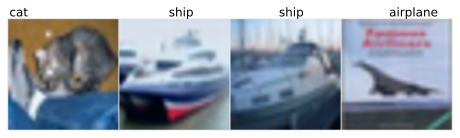

In [10]:
transform_test = transforms.Compose([
            transforms.Resize(args['input_size'], interpolation=3),  # Bicubic interpolation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset_test = CIFAR10(root=args['data_path'], train=False, transform=transform_test, download=True)

data_loader_test = data.DataLoader(
        dataset_test,
        shuffle=False,
        batch_size=args['batch_size'],
        num_workers=args['num_workers'],
        drop_last=False,
    )

# Get class names from original dataset 
class_names = dataset_test.classes

NUM_IMAGES = 4
CIFAR_images = torch.stack([dataset_test[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
#plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)

# Overlay class names
for i in range(NUM_IMAGES):
    # Get class name
    cls = class_names[dataset_test[i][1]]
    
    # Add text
    #plt.text(i*32, 0, cls, fontsize=12, color='black') 

    # Position text 
    if i > 0:
        x = i*224 + 100 + 4 
    else:
        x = i*224  + 4

    y = -5  
    # Add text
    plt.text(x, y, cls, fontsize=12, color='black')
plt.axis('off')
plt.show()
plt.close()


tensor([[-1.0216,  0.6338,  0.3386,  2.2051, -2.1402,  1.6381,  1.5271, -3.2309,
          1.4716, -1.5310]], device='cuda:0')
tensor([[ 3.5649,  6.6311, -2.2359, -1.9342, -3.0606, -4.3048, -3.4009, -4.6353,
          7.1414,  4.3336]], device='cuda:0')
tensor([[ 1.9380,  1.7029, -1.5866, -0.3003, -0.2944, -3.5976, -3.0411, -3.2832,
          6.5661,  1.5139]], device='cuda:0')
tensor([[ 2.8584,  0.7407,  1.3201, -1.3642, -0.5719, -3.4699, -4.5658, -1.5889,
          4.6424, -0.1062]], device='cuda:0')
tensor([[-0.8333, -2.1898,  1.4961,  2.3364,  2.1386,  0.0470,  5.8539, -1.9458,
         -3.4153, -4.3229]], device='cuda:0')
tensor([[-2.8616, -3.1188, -0.0252,  2.6930,  0.9805,  1.9290,  5.5746, -0.4584,
         -3.8497, -1.5020]], device='cuda:0')
tensor([[ 1.3491,  5.3280, -1.5901,  2.1671, -3.9696,  1.3192, -1.1001, -2.3107,
          0.2774, -0.2281]], device='cuda:0')
tensor([[ 0.6993, -1.9448,  1.4391,  0.7543,  1.2435, -0.2651,  1.8357,  0.2702,
         -2.6399, -2.4604]], d

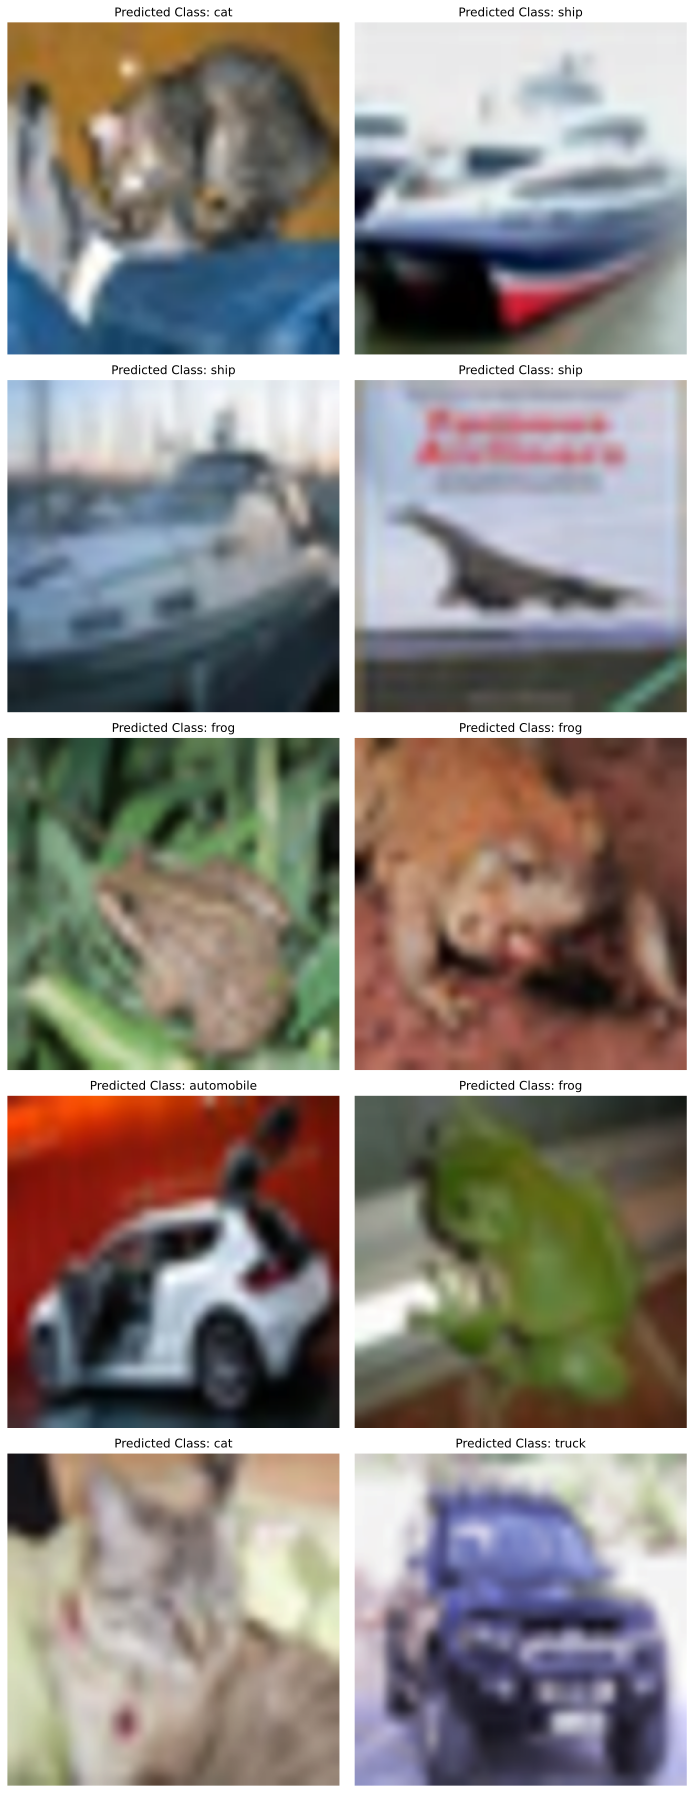

In [11]:
def run_n_images(n, dataset_test, model, class_names):
    fig, axs = plt.subplots(int(np.ceil(n/2)), 2, figsize=(10, 5*n/2))  # adjust figsize to your preference
    axs = axs.ravel()  # Flatten the axis array for easier indexing

    for i in range(n):
        image = dataset_test[i][0]
        predicted_class_idx = run_one_image(image, model_mae, class_names, display=False) #run_one_image(image, model)
        predicted_class_name = class_names[predicted_class_idx]
        
        # Convert image from torch tensor to numpy array
        image_np = image.cpu().numpy()
        
        # Convert (C, H, W) format back to (H, W, C) for visualization
        if image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))

        # Normalize the image
        image_np = np.clip((image_np * imagenet_std + imagenet_mean) * 255, 0, 255).astype(np.uint8)

        axs[i].imshow(image_np)
        axs[i].set_title(f"Predicted Class: {predicted_class_name}", fontsize=12)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
N = 10  # or however many images you want
run_n_images(N, dataset_test, model_mae, class_names)

In [12]:
from timm.utils import accuracy

def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()

    # switch to evaluation mode
    model.eval()

    acc1_sum, acc5_sum = 0.0, 0.0
    total_samples = 0
    total_loss = 0.0

    for idx, (images, target) in enumerate(data_loader):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.no_grad(): #, torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_sum += acc1.item() * images.size(0)
        acc5_sum += acc5.item() * images.size(0)
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

        # Logging progress every 10 iterations
        if (idx + 1) % 10 == 0:
            print(f"Iteration {idx + 1}/{len(data_loader)}: Current Acc@1 {acc1.item():.3f}, Current Acc@5 {acc5.item():.3f}, Current Loss {loss.item():.3f}")

    avg_acc1 = acc1_sum / total_samples
    avg_acc5 = acc5_sum / total_samples
    avg_loss = total_loss / total_samples

    print(f'* Acc@1 {avg_acc1:.3f} Acc@5 {avg_acc5:.3f} Avg Loss {avg_loss:.3f}')
    return {"acc1": avg_acc1, "acc5": avg_acc5, "avg_loss": avg_loss}


In [13]:
evaluate(data_loader_test, model_mae, device)

Iteration 10/157: Current Acc@1 70.312, Current Acc@5 100.000, Current Loss 0.753
Iteration 20/157: Current Acc@1 68.750, Current Acc@5 98.438, Current Loss 0.849
Iteration 30/157: Current Acc@1 76.562, Current Acc@5 95.312, Current Loss 0.838
Iteration 40/157: Current Acc@1 50.000, Current Acc@5 93.750, Current Loss 1.350
Iteration 50/157: Current Acc@1 73.438, Current Acc@5 100.000, Current Loss 0.794
Iteration 60/157: Current Acc@1 76.562, Current Acc@5 98.438, Current Loss 0.830
Iteration 70/157: Current Acc@1 73.438, Current Acc@5 98.438, Current Loss 0.873
Iteration 80/157: Current Acc@1 67.188, Current Acc@5 95.312, Current Loss 1.051
Iteration 90/157: Current Acc@1 78.125, Current Acc@5 98.438, Current Loss 0.719
Iteration 100/157: Current Acc@1 65.625, Current Acc@5 100.000, Current Loss 0.929
Iteration 110/157: Current Acc@1 60.938, Current Acc@5 98.438, Current Loss 1.119
Iteration 120/157: Current Acc@1 70.312, Current Acc@5 96.875, Current Loss 0.940
Iteration 130/157: Cur

{'acc1': 68.89, 'acc5': 97.75, 'avg_loss': 0.8986682962417603}